In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch, Sbopen
import pandas as pd

In [2]:
parser = Sbopen()
df, related, freeze, tactics = parser.event(69301)

## Preparing THe data.

In [3]:
subs_mask = (df.type_name == "Substitution") & (df.team_name == "England Women's")
subs_index = df.loc[subs_mask].iloc[0]['index']

In [4]:
subs_index

1763

In [5]:
mask_england = (df.type_name == "Pass") & (df.team_name == "England Women's") & (df.index < subs_index) & (df.outcome_name.isnull()) & (df.sub_type_name != "Throw-in")
england_passes_df = df.loc[mask_england, ['x', 'y', 'end_x', 'end_y', "player_name", "pass_recipient_name"]]

In [6]:
england_passes_df['player_name'] = england_passes_df['player_name'].apply(lambda x: str(x).split()[-1])
england_passes_df['pass_recipient_name'] = england_passes_df['pass_recipient_name'].apply(lambda x: str(x).split()[-1])

In [7]:
england_passes_df

,x,y,end_x,end_y,player_name,pass_recipient_name
4,60.0,40.0,61.9,40.9,White,Kirby
8,82.6,37.6,78.4,58.5,Kirby,Bronze
11,84.7,65.3,98.9,77.9,Bronze,Parris
14,94.7,75.5,93.3,64.3,Parris,Scott
63,5.2,8.3,10.8,5.5,Moore,Mead
...,...,...,...,...,...,...
1744,52.5,42.0,40.0,34.1,Greenwood,McManus
1747,40.0,34.1,39.0,58.0,McManus,Houghton
1750,39.7,59.3,49.2,76.7,Houghton,Bronze
1753,49.8,75.2,50.5,63.1,Bronze,Kirby


In [8]:
scatter_df = pd.DataFrame()
for i, name in enumerate(england_passes_df['player_name'].unique()):
    passx = england_passes_df.loc[england_passes_df['player_name'] == name]['x'].to_numpy()
    recx = england_passes_df.loc[england_passes_df['pass_recipient_name'] == name]['end_x'].to_numpy()

    passy = england_passes_df.loc[england_passes_df['player_name'] == name]['y'].to_numpy()
    recy = england_passes_df.loc[england_passes_df['pass_recipient_name'] == name]['end_y'].to_numpy()
    scatter_df.at[i, 'player_name'] = name

    # Make sure that x and y location for each circle representing the player is avg of passes.
    scatter_df.at[i, 'x'] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, 'y'] = np.mean(np.concatenate([passy, recy]))

    scatter_df.at[i, 'no'] = scatter_df.loc[scatter_df['player_name'] == name].count().iloc[0]

scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)

In [26]:
england_passes_df['pair_key'] = england_passes_df.apply(lambda x: "_".join(sorted([x['player_name'], x['pass_recipient_name']])), axis=1)
lines_df = england_passes_df.groupby(['pair_key']).x.count().reset_index()
lines_df.rename({ 'x': 'pass_count' }, axis='columns', inplace=True)
lines_df = lines_df[lines_df['pass_count'] > 1]

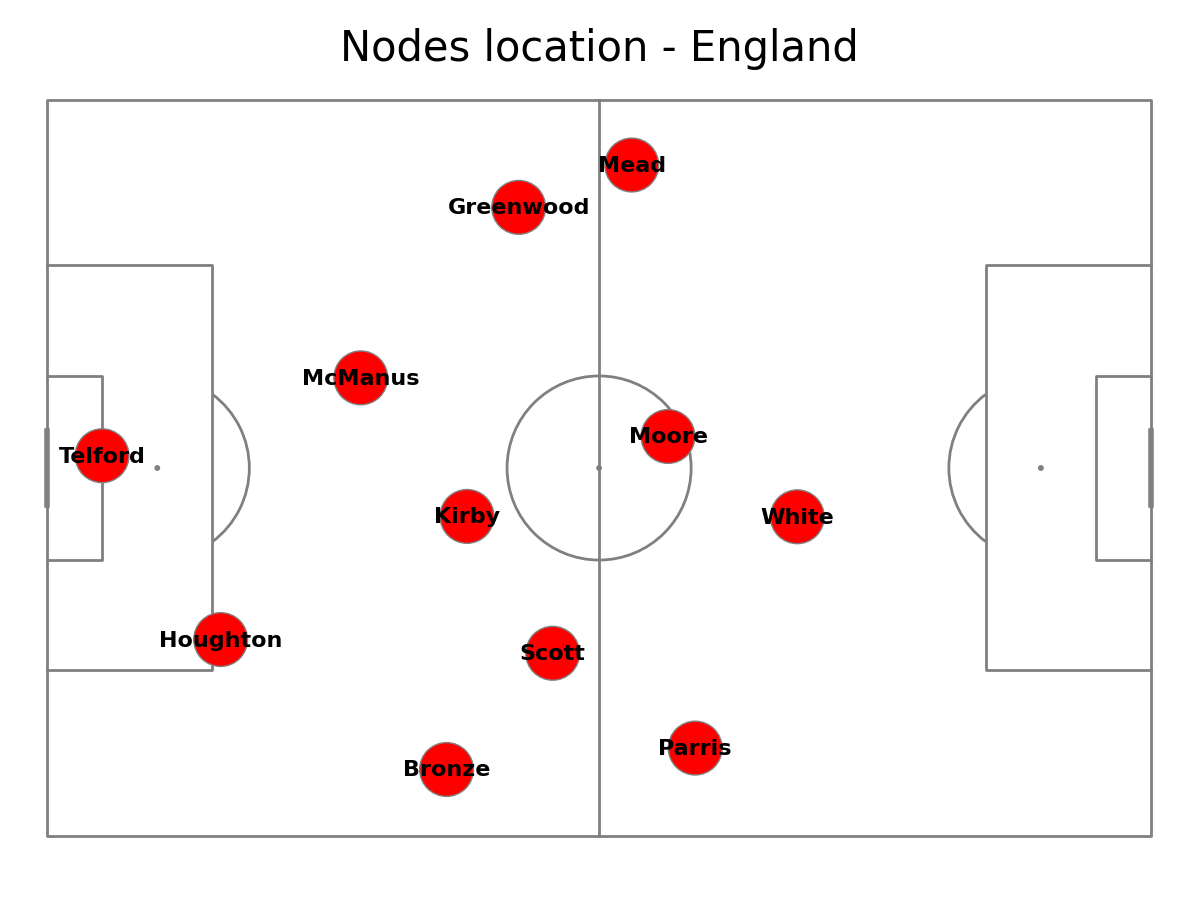

In [27]:
# Drawing the pitch.
pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='red', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)

for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)

fig.suptitle("Nodes location - England", fontsize = 30)
plt.show()

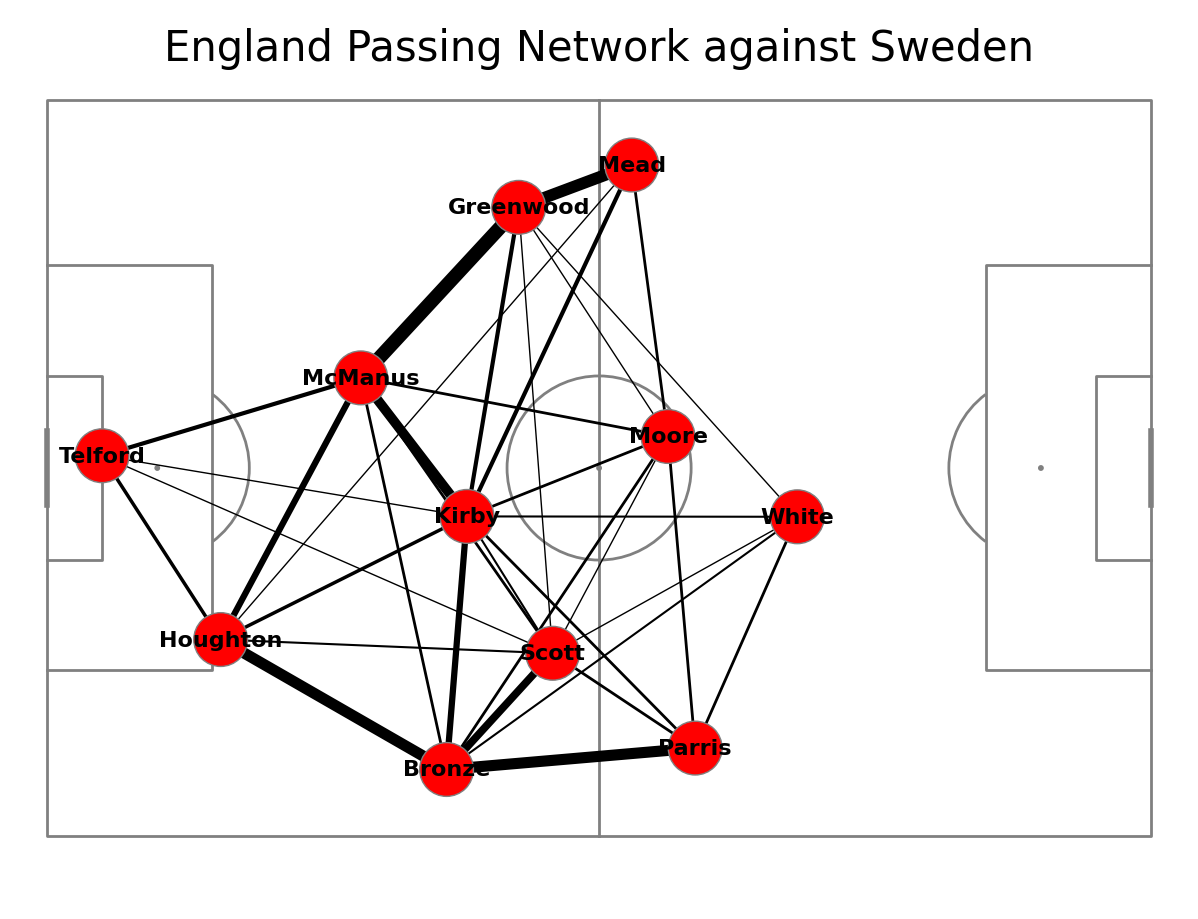

In [28]:
pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='red', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)

for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)


for i, row in lines_df.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        #take the average location of players to plot a line between them
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
        num_passes = row["pass_count"]
        #adjust the line width so that the more passes, the wider the line
        line_width = (num_passes / lines_df['pass_count'].max() * 10)
        #plot lines on the pitch
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=1, lw=line_width, zorder=2, color="black", ax = ax["pitch"])

fig.suptitle("England Passing Network against Sweden", fontsize = 30)
plt.show()

## Calculating Centralisation.

To calculate centralisation index we need to calculate number of passes made by each player.
Then, we calculate the denominator - the sum of all passes multiplied by (number of players - 1) -> 10.
To calculate the numerator we sum the difference between maximal number of successful passes by 1 player,
and number of successful passes by each player.

We calcylate the index dividing the numerator by denominator.

In [31]:
# Calculate the number of successful passes by player.
no_passes = england_passes_df.groupby(['player_name']).x.count().reset_index()
no_passes.rename({ 'x': 'pass_count' }, axis='columns', inplace=True)

# find one who made most passes.
max_no = no_passes['pass_count'].max()

# calculate the denominator - 10 * the total sum of passes.
denominator = 10 * no_passes['pass_count'].sum()

# calculate the nominator
nominator = (max_no - no_passes['pass_count']).sum()

# calculate the centralisation index.
centralisation_index = nominator / denominator

print("Centralisation index is ", centralisation_index)


Centralisation index is  0.07


## Challenge

Make a passing network from England - Sweden game only with passes forward for England!

In [14]:
england_passes_df

,x,y,end_x,end_y,player_name,pass_recipient_name,pair_key
4,60.0,40.0,61.9,40.9,White,Kirby,Kirby_White
8,82.6,37.6,78.4,58.5,Kirby,Bronze,Bronze_Kirby
11,84.7,65.3,98.9,77.9,Bronze,Parris,Bronze_Parris
14,94.7,75.5,93.3,64.3,Parris,Scott,Parris_Scott
63,5.2,8.3,10.8,5.5,Moore,Mead,Mead_Moore
...,...,...,...,...,...,...,...
1744,52.5,42.0,40.0,34.1,Greenwood,McManus,Greenwood_McManus
1747,40.0,34.1,39.0,58.0,McManus,Houghton,Houghton_McManus
1750,39.7,59.3,49.2,76.7,Houghton,Bronze,Bronze_Houghton
1753,49.8,75.2,50.5,63.1,Bronze,Kirby,Bronze_Kirby


In [15]:
forward_passes_mask = (england_passes_df.x < england_passes_df.end_x) & (england_passes_df.y < england_passes_df.end_y)

In [18]:
foward_passes_df = england_passes_df[forward_passes_mask]

In [21]:
foward_passes_df

,x,y,end_x,end_y,player_name,pass_recipient_name,pair_key
4,60.0,40.0,61.9,40.9,White,Kirby,Kirby_White
11,84.7,65.3,98.9,77.9,Bronze,Parris,Bronze_Parris
81,24.2,12.2,37.9,65.0,Mead,Bronze,Bronze_Mead
176,14.6,22.5,28.1,69.2,McManus,Bronze,Bronze_McManus
221,3.1,64.8,14.6,65.5,Houghton,Kirby,Houghton_Kirby
238,26.3,76.7,36.3,77.9,Houghton,Bronze,Bronze_Houghton
250,5.9,55.9,13.9,73.0,Houghton,Bronze,Bronze_Houghton
256,20.2,62.7,31.6,77.9,Kirby,Parris,Kirby_Parris
344,57.8,67.4,64.1,76.9,Bronze,Parris,Bronze_Parris
353,34.2,42.6,48.7,52.4,McManus,Kirby,Kirby_McManus


In [29]:
scatter_df = pd.DataFrame()
for i, name in enumerate(foward_passes_df['player_name'].unique()):
    passx = foward_passes_df.loc[foward_passes_df['player_name'] == name]['x'].to_numpy()
    recx = foward_passes_df.loc[foward_passes_df['pass_recipient_name'] == name]['end_x'].to_numpy()

    passy = foward_passes_df.loc[foward_passes_df['player_name'] == name]['y'].to_numpy()
    recy = foward_passes_df.loc[foward_passes_df['pass_recipient_name'] == name]['end_y'].to_numpy()
    scatter_df.at[i, 'player_name'] = name

    # Make sure that x and y location for each circle representing the player is avg of passes.
    scatter_df.at[i, 'x'] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, 'y'] = np.mean(np.concatenate([passy, recy]))

    scatter_df.at[i, 'no'] = scatter_df.loc[scatter_df['player_name'] == name].count().iloc[0]

scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)

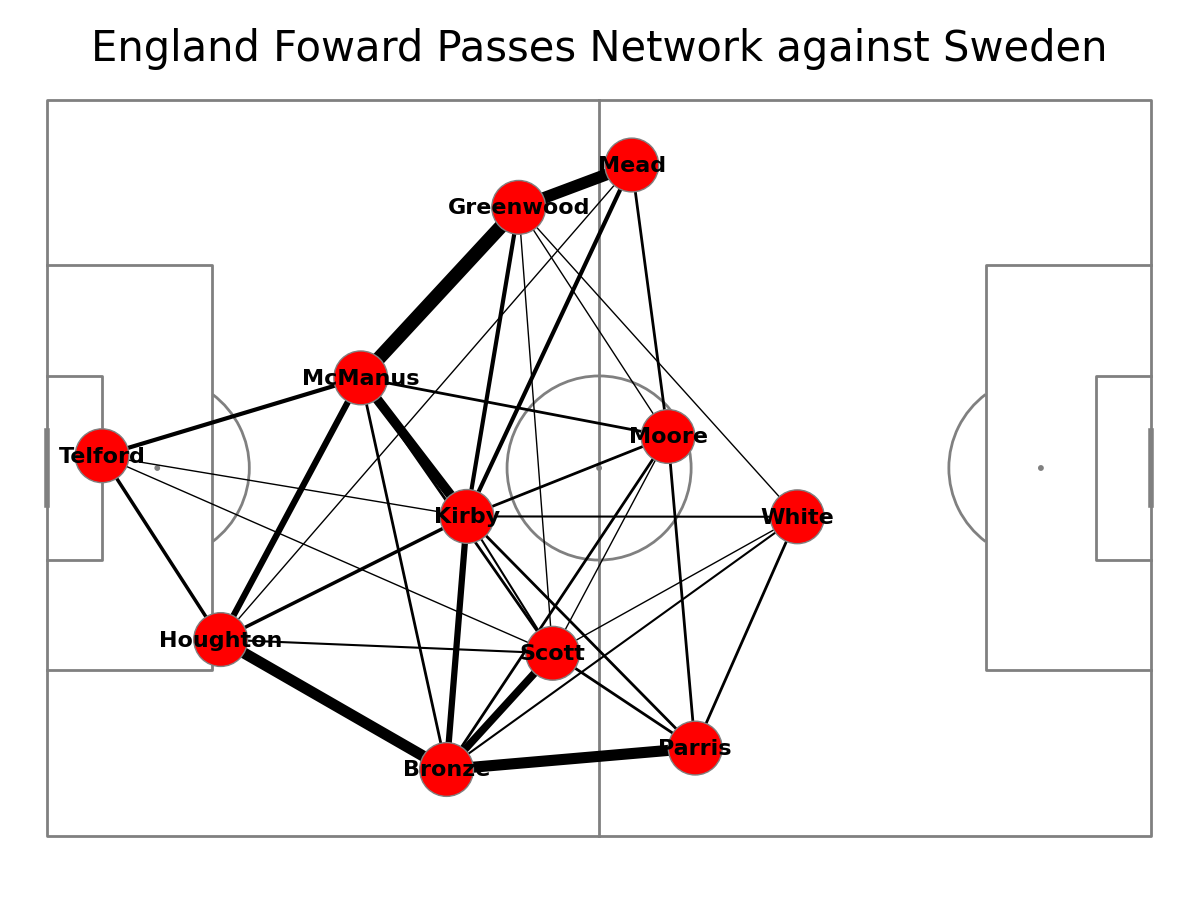

In [30]:
pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='red', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)

for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)


for i, row in lines_df.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        #take the average location of players to plot a line between them
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
        num_passes = row["pass_count"]
        #adjust the line width so that the more passes, the wider the line
        line_width = (num_passes / lines_df['pass_count'].max() * 10)
        #plot lines on the pitch
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=1, lw=line_width, zorder=2, color="black", ax = ax["pitch"])

fig.suptitle("England Foward Passes Network against Sweden", fontsize = 30)
plt.show()